---
title: "Character-Level Language Model"
subtitle: "How an RNN learns to generate names one character at a time — and what it teaches us about language models"
image: feature.png
title-block-banner: feature.png
date: "2018-02-22"
date-modified: "2024-12-10"
categories: ["NLP",  "Deep Learning"]
format:
  html:
    code-fold: true
    code-tools: true
jupyter: python3
---

## The Simplest Language Model You Can Actually Build

Every time Gmail suggests a reply or a speech recognition system transcribes your words, a language model is predicting the next token. State-of-the-art systems like Google's Neural Machine Translation do this with millions of parameters and subword tokens — but the *core idea* is identical to what we'll build here: **predict the next character given everything that came before it.**

In this post, we'll build a character-level language model from scratch using a Recurrent Neural Network (RNN). We'll train it on a dataset of human names, and by the end, it will generate plausible-sounding new names character by character. Along the way, we'll cover the same fundamental concepts that power production NLP systems — from this toy RNN to large-scale neural machine translation: sequential prediction, backpropagation through time, gradient instabilities, and the creativity-coherence trade-off in sampling.

### Roadmap

| Section | What You'll Learn | Why It Matters |
|---|---|---|
| **The Core Idea** | How sequence prediction decomposes into conditional probabilities | The same factorization underlies every autoregressive neural language model |
| **Forward Pass** | One-hot encoding → hidden state → softmax → loss | The mechanics of a single training step |
| **Backpropagation Through Time** | How gradients flow backward across shared weights | Why RNNs struggle with long sequences (and why we clip gradients) |
| **Sampling** | Controlling randomness in generation | The entropy knob that controls text generation quality |
| **Training & Results** | Putting it all together and generating names | Seeing the model go from gibberish to "Yasira" |

## The Core Idea: One Character at a Time

A **statistical language model** learns the joint probability distribution over sequences of tokens. For a sequence of $T$ characters, we want to maximize:

$$P(c_1, c_2, \ldots, c_T) = \prod_{t=1}^{T} P(c_t \mid c_1, \ldots, c_{t-1})$$

In plain English: the probability of the full sequence equals the product of each character's probability *given everything before it*. This is the chain rule of probability — nothing more — and it's the same factorization used by large-scale neural language models for machine translation and speech recognition. The only difference is scale: we work with 27 characters, while production systems work with vocabularies of tens of thousands of subword tokens.

::: {.callout-note}
## The Same Core Loop
Every autoregressive neural language model — from this character RNN to large LSTM language models used in machine translation — runs the same loop: (1) encode the input, (2) update an internal state, (3) predict the next token, (4) consume the prediction as the next input. The architecture and scale differ enormously, but the loop is identical.
:::

### Why RNNs?

We need a model that can process sequences of *variable length* while maintaining memory of past inputs. An RNN does this by carrying a **hidden state** $h^t$ that gets updated at each time step as a function of the current input and the previous hidden state. In theory, the hidden state at the last time step captures the entire input history — it's a compressed summary of everything the model has seen so far.

### Worked Example: Generating "imad"

Let's trace through how the model processes a single name to make this concrete.

**Step 1: Build a vocabulary.** Collect all unique characters and assign each an integer index:
`{"a": 0, "d": 1, "i": 2, "m": 3}`. So "imad" becomes `[2, 3, 0, 1]`.

**Step 2: Align inputs and targets.** The input at each time step is the *previous* character, and the target is the *current* character. We initialize $x^1 = \vec{0}$ (a zero vector — "no previous character") and shift:

| Time step | Input ($x^t$) | Target ($y^t$) |
|---|---|---|
| 1 | $\vec{0}$ | "i" (2) |
| 2 | "i" (2) | "m" (3) |
| 3 | "m" (3) | "a" (0) |
| 4 | "a" (0) | "d" (1) |

**Step 3: At each time step**, the model: converts the input to a one-hot vector → computes the hidden state → produces a probability distribution over the vocabulary via softmax → measures the loss against the true target.

The goal: make the probability assigned to the correct next character as high as possible. We measure this with **cross-entropy loss** and update parameters via gradient descent.

<p align="left">
<img src="images/char_level_example.png" style="width: 800px; height: 600px"><br>
<caption><center><u><b><font color="00b7e4">Figure 1:</font></b></u> Illustrative example of character-level language model using RNN. Green values are the target probabilities we want to maximize; red values should be minimized. Notice that $h^4$ carries information about all previous characters.</center></caption>
</p>

::: {.callout-tip}
## Teacher Forcing
During training, we feed the *true* target character as the next input — not the model's own prediction. This is called **teacher forcing** and it stabilizes training by preventing error accumulation across time steps. At generation time, we switch to feeding the model's own predictions back in (autoregressive decoding).
:::

**Key takeaway:** A character-level language model factorizes the probability of a name into a product of conditional probabilities, one per character. An RNN processes these sequentially, maintaining a hidden state that (in theory) summarizes all past context.

## Training Setup

Now that we understand the core idea, let's set up the training pipeline. The decisions made here — dataset, architecture variant, and optimization strategy — directly affect what the model can learn.

### Dataset & Architecture

The [dataset](http://deron.meranda.us/data/census-derived-all-first.txt) contains **5,163 names** from US census data: 4,275 male names, 1,219 female names, and 331 names that can be either.

We'll use a **many-to-many RNN** architecture where the number of input time steps equals the number of output time steps ($T_x = T_y$). At each step, the model reads one character and predicts the next — input and output are perfectly synced.

<p align="left">
<img src="images/rnn_architecture.png" style="width: 600px; height: 600px"><br>
<caption><center><u><b><font color="00b7e4">Figure 2:</font></b></u> RNN architecture: many to many — each time step produces a prediction</center></caption>
</p>

The character-level language model will be trained on names; which means after we're done with training the model, we'll be able to generate interesting names :).

In this section, we'll go over four main parts:

1. Forward propagation.
2. Backpropagation
3. Sampling
4. Fitting the model

::: {.callout-important}
## SGD with Batch Size 1
We train with **stochastic gradient descent** where each "batch" is a single name. The model runs forward and backward on one name, updates parameters, then moves to the next. This makes the loss noisy (high variance) but allows the model to learn from the idiosyncrasies of each name individually. We smooth the loss with an exponential moving average to track the trend.
:::

::: {.callout-note}
## Practical Consideration: Batch Size & Throughput
In production NLP systems (e.g., neural machine translation), batch size 1 would be very slow — the hardware can't parallelize across a single short sequence. Real systems use mini-batches of hundreds of sequences, padded to uniform length, to better utilize GPU resources. But the *math* is identical: gradient descent on cross-entropy loss over next-token predictions. The only difference is how many examples contribute to each gradient update.
:::

## Forward Propagation: From Characters to Probabilities

The forward pass transforms raw characters into a probability distribution over the next character. Let's trace through each stage.

### Step-by-Step Walkthrough

**1. Vocabulary Construction**

We build two dictionaries from the unique lowercase characters in the dataset:

- `chars_to_idx`: maps each character to an integer (e.g., `"a" → 1`, `"z" → 26`). Index `0` is reserved for the newline character `"\n"`, which serves as our **end-of-sequence (EOS)** token — the model learns to "stop" by predicting `"\n"`.
- `idx_to_chars`: the reverse mapping, used to decode model output back into characters.

**2. Parameter Initialization**

Weights are initialized from a small random normal distribution (to break symmetry so different hidden units learn different features). Biases are initialized to zeros.

| Parameter | Connects | Shape |
|---|---|---|
| $W_{xh}$ | Input $x^t$ → Hidden $h^t$ | `(n_h, vocab_size)` |
| $W_{hh}$ | Previous hidden $h^{t-1}$ → Current hidden $h^t$ | `(n_h, n_h)` |
| $b$ | Hidden state bias | `(n_h, 1)` |
| $W_{hy}$ | Hidden $h^t$ → Output $o^t$ | `(vocab_size, n_h)` |
| $c$ | Output bias | `(vocab_size, 1)` |

**3. One-Hot Encoding**

Each character is converted to a one-hot vector of dimension `vocab_size × 1`. The first input $x^1 = \vec{0}$ (all zeros — "no previous character"). From $t = 2$ onward, $x^{t} = y^{t-1}$ (the previous target character).

The last target for every name is `"\n"`, so the model learns *when to stop generating*.

**4. Hidden State Computation**

$$h^t = \tanh(W_{hh} \cdot h^{t-1} + W_{xh} \cdot x^t + b) \tag{1}$$

The **tanh** activation squashes values to $[-1, 1]$. One practical advantage: near the origin, tanh resembles the identity function, which helps gradients flow during early training when weights are small.

**5. Output & Softmax**

$$o^t = W_{hy} \cdot h^t + c \tag{2}$$
$$\hat{y}^t = \text{softmax}(o^t) = \frac{e^{o^t_i}}{\sum_j e^{o^t_j}} \tag{3}$$

The softmax converts raw logits into a valid probability distribution — all values between 0 and 1, summing to 1. Each entry $\hat{y}^t[i]$ is the predicted probability that character $i$ comes next.

**6. Cross-Entropy Loss**

$$\mathcal{L}^t = -\log \hat{y}^t[y^t] \tag{4}$$
$$\mathcal{L} = \sum_{t=1}^{T} \mathcal{L}^t \tag{5}$$

We only care about the probability the model assigned to the *correct* next character. The negative log makes this a loss: high probability → low loss, low probability → high loss.

Since we'll be using SGD, the loss will be noisy and have many oscillations, so it's a good practice to smooth out the loss using exponential weighted average.

::: {.callout-tip}
## Why Cross-Entropy?
Cross-entropy loss is equivalent to minimizing the KL divergence between the model's predicted distribution and the true distribution (which is a one-hot vector). It's also the negative log-likelihood of the data under the model — so minimizing cross-entropy is the same as maximum likelihood estimation.
:::

::: {.callout-note}
## Perplexity: The Standard Language Model Metric
In language modeling, we typically report **perplexity** = $e^{\mathcal{L}/T}$, which is the exponential of the average per-token cross-entropy loss. A perplexity of 27 means the model is as uncertain as if it were choosing uniformly among 27 characters. Lower is better. State-of-the-art word-level LSTM language models on the Penn Treebank benchmark achieve perplexity around 58 ([Merity et al., 2018](https://arxiv.org/abs/1708.02182)), down from over 80 just a couple of years ago.
:::

In [1]:
# | echo: false
%load_ext lab_black
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Load packages
# | warning: false
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

os.chdir("../scripts/")
from character_level_language_model import (
    initialize_parameters,
    initialize_rmsprop,
    softmax,
    smooth_loss,
    update_parameters_with_rmsprop,
)

%matplotlib inline
sns.set_context("notebook")
plt.style.use("fivethirtyeight")

In [3]:
def rnn_forward(x, y, h_prev, parameters):
    """
    Implement one Forward pass on one name.

    Arguments
    ---------
    x : list
        list of integers for the index of the characters in the example
        shifted one character to the right.
    y : list
        list of integers for the index of the characters in the example.
    h_prev : array
        last hidden state from the previous example.
    parameters : python dict
        dictionary containing the parameters.

    Returns
    -------
    loss : float
        cross-entropy loss.
    cache : tuple
        contains three python dictionaries:
            xs -- input of all time steps.
            hs -- hidden state of all time steps.
            probs -- probability distribution of each character at each time
                step.
    """
    # Retrieve parameters
    Wxh, Whh, b = parameters["Wxh"], parameters["Whh"], parameters["b"]
    Why, c = parameters["Why"], parameters["c"]

    # Initialize inputs, hidden state, output, and probabilities dictionaries
    xs, hs, os, probs = {}, {}, {}, {}

    # Initialize x0 to zero vector
    xs[0] = np.zeros((vocab_size, 1))

    # Initialize loss and assigns h_prev to last hidden state in hs
    loss = 0
    hs[-1] = np.copy(h_prev)

    # Forward pass: loop over all characters of the name
    for t in range(len(x)):
        # Convert to one-hot vector
        if t > 0:
            xs[t] = np.zeros((vocab_size, 1))
            xs[t][x[t]] = 1
        # Hidden state
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t - 1]) + b)
        # Logits
        os[t] = np.dot(Why, hs[t]) + c
        # Probs
        probs[t] = softmax(os[t])
        # Loss
        loss -= np.log(probs[t][y[t], 0])

    cache = (xs, hs, probs)

    return loss, cache

## Backpropagation Through Time (BPTT)

Computing gradients for an RNN isn't quite like standard backpropagation — and the difference has profound consequences for what these models can and cannot learn.

### Why BPTT Is Different

In a standard feedforward network, each layer has its *own* weights. In an RNN, **the same weights are shared across all time steps**. When we unroll the RNN across time, it looks like a very deep feedforward network — but with tied weights. This means the gradient of the loss with respect to any shared parameter must be **summed across all time steps**.

We start at the last time step $T$ and propagate the loss backward through the entire sequence, accumulating gradients at each step.

<p align="left">
<img src="images/backprop.png" style="width: 800px; height: 400px"><br>
<caption><center><u><b><font color="00b7e4">Figure 3:</font></b></u> Backpropagation Through Time — gradients flow backward from the loss at each time step, accumulating across the shared weights</center></caption>
</p>

### The Gradient Clipping Problem

RNN loss landscapes are known for having **steep cliffs** — regions where the loss changes dramatically over a tiny change in parameters. When the gradient hits one of these cliffs, it can become enormous, causing a single update to overshoot the minimum and undo many iterations of progress.

Why does this happen? The gradient is a *linear* approximation of the loss surface. It captures the local slope but knows nothing about curvature. A steep cliff means the local slope is huge, but the optimal step size is actually tiny.

The fix is simple and effective: **gradient clipping**. Before updating, we clip every gradient element to the interval $[-5, 5]$. If any gradient value exceeds these bounds, it's capped. This prevents catastrophic updates while preserving the gradient direction.

::: {.callout-important}
## Vanishing & Exploding Gradients
Because the same weight matrix $W_{hh}$ is multiplied at each time step, the gradient either grows or shrinks *exponentially* with sequence length:

- If the dominant eigenvalue of $W_{hh}$ is **< 1** → gradients **vanish** (the model can't learn long-range dependencies)
- If it's **> 1** → gradients **explode** (training becomes unstable)

Gradient clipping addresses exploding gradients. Vanishing gradients require architectural changes — which is exactly what LSTMs ([Hochreiter & Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf)) and the recently proposed Transformer architecture ([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)) were designed to solve.
:::

### The Gradient Equations

For completeness, here are the BPTT gradient equations. The key insight is that each gradient sums contributions across all time steps, and the hidden state gradient at time $t$ receives contributions from *both* the output at time $t$ and the hidden state at time $t+1$ (the future).

$$\nabla_{o^t}\mathcal{L} = \widehat{y^t} - y^t\tag{6}$$
$$\nabla_{W_{hy}}\mathcal{L} = \sum_t \nabla_{o^t}\mathcal{L}\cdot{h^t}^T\tag{7}$$
$$\nabla_{c}\mathcal{L} = \sum_t \nabla_{o^t}\mathcal{L} \tag{8}$$
$$\nabla_{h^t}\mathcal{L} = W_{hy}^T\cdot\nabla_{o^t}\mathcal{L} + \underbrace { W_{hh}^T\cdot\nabla_{h^{t + 1}}\mathcal{L} * (1 - tanh(W_{hh}h^{t} + W_{xh}x^{t + 1} + b) ^ 2)}_{dh_{next}} \tag{9}$$
$$\nabla_{h^{t - 1}}\mathcal{L} = W_{hh}^T\cdot\nabla_{h^t}\mathcal{L} * (1 - tanh(h^t) ^ 2)\tag{10}$$
$$\nabla_{x^t}\mathcal{L} = W_{xh}^T\cdot\nabla_{h^t}\mathcal{L} * (1 - tanh(W_{hh}\cdot h^{t-1} + W_{xh}\cdot x^t + b) ^ 2)\tag{11}$$
$$\nabla_{W_{hh}}\mathcal{L} = \sum_t \nabla_{h^t}\mathcal{L} * (1 - tanh(W_{hh}\cdot h^{t-1} + W_{xh}\cdot x^t + b) ^ 2)\cdot{h^{t - 1}}^T\tag{12}$$
$$\nabla_{W_{xh}}\mathcal{L} = \sum_t \nabla_{h^t}\mathcal{L} * (1 - tanh(W_{hh}\cdot h^{t-1} + W_{xh}\cdot x^t + b) ^ 2) . {x^t}^T\tag{13}$$
$$\nabla_{b}\mathcal{L} = \sum_t \nabla_{h^t}\mathcal{L} * (1 - tanh(h^t) ^ 2) \tag{14}$$

At the last time step $T$, we initialize $dh_{next}$ to zeros since there is no future to backpropagate from.

::: {.callout-tip}
## Reading the Equations
The $(1 - tanh^2)$ terms are the derivative of $\tanh$. If you squint, the structure is always: **upstream gradient × local Jacobian × input to this operation**. That's the chain rule applied at each node — the same pattern used by automatic differentiation frameworks like TensorFlow and PyTorch.
:::

### Optimizer: RMSProp

Since SGD with batch size 1 produces very noisy gradients, we use **[Root Mean Squared Propagation (RMSProp)](https://nbviewer.jupyter.org/github/ImadDabbura/Deep-Learning/blob/master/posts/Optimization-Algorithms.ipynb)** — an adaptive learning rate method that divides each gradient by a running average of its recent magnitude. This dampens updates for parameters with consistently large gradients and amplifies updates for parameters with consistently small gradients, leading to more stable convergence.

::: {.callout-note}
## Practical Consideration: Adaptive Optimizers
RMSProp belongs to the family of adaptive learning rate methods, alongside Adagrad and Adam ([Kingma & Ba, 2015](https://arxiv.org/abs/1412.6980)). Adam combines RMSProp's adaptive second moment with a momentum term (first moment) and is currently the most popular optimizer for training deep networks, especially for NLP tasks like machine translation and language modeling.
:::

**Key takeaway:** BPTT computes gradients by unrolling the RNN through time and summing gradient contributions across all time steps. Gradient clipping prevents explosive updates, but vanishing gradients require architectural solutions (LSTM, GRU, or attention mechanisms).

In [4]:
def clip_gradients(gradients, max_value):
    """
    Implements gradient clipping element-wise on gradients to be between the
    interval [-max_value, max_value].

    Arguments
    ----------
    gradients : python dict
        dictionary that stores all the gradients.
    max_value : scalar
        edge of the interval [-max_value, max_value].

    Returns
    -------
    gradients : python dict
        dictionary where all gradients were clipped.
    """
    for grad in gradients.keys():
        np.clip(gradients[grad], -max_value, max_value, out=gradients[grad])

    return gradients


def rnn_backward(y, parameters, cache):
    """
    Implements Backpropagation on one name.

    Arguments
    ---------
    y : list
        list of integers for the index of the characters in the example.
    parameters : python dict
        dictionary containing the parameters.
    cache : tuple
            contains three python dictionaries:
                xs -- input of all time steps.
                hs -- hidden state of all time steps.
                probs -- probability distribution of each character at each time
                    step.

    Returns
    -------
    grads : python dict
        dictionary containing all the gradients.
    h_prev : array
        last hidden state from the current example.
    """
    # Retrieve xs, hs, and probs
    xs, hs, probs = cache

    # Initialize all gradients to zero
    dh_next = np.zeros_like(hs[0])

    parameters_names = ["Whh", "Wxh", "b", "Why", "c"]
    grads = {}
    for param_name in parameters_names:
        grads["d" + param_name] = np.zeros_like(parameters[param_name])

    # Iterate over all time steps in reverse order starting from Tx
    for t in reversed(range(len(xs))):
        dy = np.copy(probs[t])
        dy[y[t]] -= 1
        grads["dWhy"] += np.dot(dy, hs[t].T)
        grads["dc"] += dy
        dh = np.dot(parameters["Why"].T, dy) + dh_next
        dhraw = (1 - hs[t] ** 2) * dh
        grads["dWhh"] += np.dot(dhraw, hs[t - 1].T)
        grads["dWxh"] += np.dot(dhraw, xs[t].T)
        grads["db"] += dhraw
        dh_next = np.dot(parameters["Whh"].T, dhraw)

    # Clip gradients after accumulating across all time steps
    grads = clip_gradients(grads, 5)

    # Get the last hidden state
    h_prev = hs[len(xs) - 1]

    return grads, h_prev

## Sampling: The Creativity-Coherence Trade-off

Training teaches the model *what* to predict. Sampling determines *how* we use those predictions to generate text — and it's where the magic (and the control) lives.

### The Entropy Spectrum

At each time step, the model outputs a conditional probability distribution over the next character: $P(c_t \mid c_1, \ldots, c_{t-1})$. Suppose at time $t = 3$, the distribution is $(0.2, 0.3, 0.4, 0.1)$. How do we pick the next character?

There are two extremes — and a useful middle ground:

| Strategy | Entropy | Behavior | Result |
|---|---|---|---|
| **Uniform random** | Maximum | Ignore the model entirely; pick any character with equal probability | Gibberish — no structure |
| **Argmax (greedy)** | Minimum | Always pick the highest-probability character | Coherent but repetitive and boring |
| **Sample from distribution** | Medium | Pick characters proportionally to their predicted probability | Creative *and* structured |

We use the middle option: **sample from the model's own distribution**. Character with probability 0.4 gets picked 40% of the time, character with probability 0.1 gets picked 10% of the time. This preserves the model's learned structure while allowing for variety. Using this sampling strategy on the above distribution, the index 0 has $20$% probability of being picked, while index 2 has $40$% probability to be picked.

<p align="left">
<img src="images/sampling.png" style="width: 800px; height: 400px"><br>
<caption><center><u><b><font color="00b7e4">Figure 4:</font></b></u> Sampling from the model's predicted distribution — a balance between randomness and coherence</center></caption>
</p>

As we increase randomness, text will loose local structure; however, as we decrease randomness, the generated text will sound more real and start to preserve its local structure.

::: {.callout-note}
## Temperature Scaling
A common extension is to introduce a **temperature** parameter $\tau$. Before applying softmax, the logits are divided by $\tau$:

$$P(c_i) = \frac{e^{o_i / \tau}}{\sum_j e^{o_j / \tau}}$$

- $\tau = 1.0$: standard sampling (what we do here)
- $\tau \to 0$: approaches argmax (greedy, deterministic)
- $\tau > 1$: flattens the distribution (more random, more "creative")

Temperature gives fine-grained control over the creativity-coherence trade-off without retraining the model. It's widely used in neural text generation systems.
:::

::: {.callout-tip}
## Why Not Always Use Argmax?
Greedy decoding (always picking the most likely character) produces the single most probable *next* character at each step, but this doesn't necessarily produce the most probable *sequence*. It can get stuck in repetitive loops and miss globally better paths. Sampling introduces the randomness needed to explore the distribution and generate diverse, interesting outputs. This is why beam search — which tracks multiple hypotheses simultaneously — is preferred over greedy decoding in tasks like machine translation.
:::

Therefore, sampling will be used at test time to generate names character by character.

**Key takeaway:** Sampling strategy controls the trade-off between creativity and coherence. Sampling from the model's distribution is a sweet spot — it respects the learned probabilities while producing diverse outputs. Temperature scaling provides an additional dial to tune this balance.

In [5]:
def sample(parameters, idx_to_chars, chars_to_idx, n, seed=None):
    """
    Implements sampling of a squence of n characters characters length. The
    sampling will be based on the probability distribution output of RNN.

    Arguments
    ---------
    parameters : python dict
        dictionary storing all the parameters of the model.
    idx_to_chars : python dict
        dictionary mapping indices to characters.
    chars_to_idx : python dict
        dictionary mapping characters to indices.
    n : scalar
        number of characters to output.
    seed : int, optional
        random seed for reproducibility.

    Returns
    -------
    sequence : str
        sequence of characters sampled.
    """
    # Retrieve parameters, shapes, and vocab size
    Whh, Wxh, b = parameters["Whh"], parameters["Wxh"], parameters["b"]
    Why, c = parameters["Why"], parameters["c"]
    n_h, n_x = Wxh.shape
    vocab_size = c.shape[0]

    # Use new-style random generator for reproducibility
    rng = np.random.default_rng(seed)

    # Initialize a0 and x1 to zero vectors
    h_prev = np.zeros((n_h, 1))
    x = np.zeros((n_x, 1))

    # Initialize empty sequence
    indices = []
    idx = -1
    counter = 0
    while counter <= n and idx != chars_to_idx["\n"]:
        # Fwd propagation
        h = np.tanh(np.dot(Whh, h_prev) + np.dot(Wxh, x) + b)
        o = np.dot(Why, h) + c
        probs = softmax(o)

        # Sample the index of the character using generated probs distribution
        idx = rng.choice(vocab_size, p=probs.ravel())

        # Get the character of the sampled index
        char = idx_to_chars[idx]

        # Add the char to the sequence
        indices.append(idx)

        # Update a_prev and x
        h_prev = np.copy(h)
        x = np.zeros((n_x, 1))
        x[idx] = 1

        counter += 1
    sequence = "".join([idx_to_chars[idx] for idx in indices if idx != 0])

    return sequence

## Putting It All Together: Training and Results

With forward propagation, BPTT, and sampling in place, we can now train the full model. Let's see how the generated names evolve as the model learns.

### Training Loop Overview

After covering all the concepts/intuitions behind character-level language model, now we're ready to fit the model. The training loop is straightforward:

1. **Shuffle** the names at the start of each epoch (reduces ordering bias)
2. For each name: convert characters to indices, run **forward pass**, compute **smoothed loss**, run **backward pass** (BPTT with gradient clipping), **update parameters** with RMSProp
3. Every 10 epochs: sample a name and print the smoothed loss

We'll use the default settings for RMSProp's hyperparameters and run the model for 100 iterations. On each iteration, we'll print out one sampled name and smoothed loss to see how the names generated start to get more interesting with more iterations as well as the loss will start decreasing. When done with fitting the model, we'll plot the loss function and generate some names.

::: {.callout-tip}
## What to Watch For
As training progresses, watch for two signals: (1) the smoothed loss should decrease steadily, and (2) the sampled names should transition from random character sequences to plausible-sounding names. If the loss plateaus early, the model may need more hidden units or a lower learning rate.
:::

In [6]:
def model(
    file_path,
    chars_to_idx,
    idx_to_chars,
    hidden_layer_size,
    vocab_size,
    num_epochs=10,
    learning_rate=0.01,
):
    """
    Implements RNN to generate characters.

    Arguments
    ---------
    file_path : str
        path to the file of the raw data.
    num_epochs : int
        number of passes the optimization algorithm to go over the training
        data.
    learning_rate : float
        step size of learning.
    chars_to_idx : python dict
        dictionary mapping characters to indices.
    idx_to_chars : python dict
        dictionary mapping indices to characters.
    hidden_layer_size : int
        number of hidden units in the hidden layer.
    vocab_size : int
        size of vocabulary dictionary.

    Returns
    -------
    parameters : python dict
        dictionary storing all the parameters of the model.
    overall_loss : list
        list stores smoothed loss per epoch.
    """
    # Get the data
    with open(file_path) as f:
        data = f.readlines()
    examples = [x.lower().strip() for x in data]

    # Initialize parameters
    parameters = initialize_parameters(vocab_size, hidden_layer_size)

    # Initialize Adam parameters
    s = initialize_rmsprop(parameters)

    # Initialize loss
    smoothed_loss = -np.log(1 / vocab_size) * 7

    # Initialize hidden state h0 and overall loss
    h_prev = np.zeros((hidden_layer_size, 1))
    overall_loss = []

    # Iterate over number of epochs
    for epoch in range(num_epochs):
        # Shuffle examples
        np.random.shuffle(examples)

        # Iterate over all examples (SGD)
        for example in examples:
            x = [None] + [chars_to_idx[char] for char in example]
            y = x[1:] + [chars_to_idx["\n"]]
            # Fwd pass
            loss, cache = rnn_forward(x, y, h_prev, parameters)
            # Compute smooth loss
            smoothed_loss = smooth_loss(smoothed_loss, loss)
            # Bwd pass
            grads, h_prev = rnn_backward(y, parameters, cache)
            # Update parameters
            parameters, s = update_parameters_with_rmsprop(parameters, grads, s)

        overall_loss.append(smoothed_loss)
        if epoch % 10 == 0:
            print(f"\033[1m\033[94mEpoch {epoch}")
            print(f"\033[1m\033[92m=======")
            # Sample one name
            print(
                f"""Sampled name: {sample(parameters, idx_to_chars, chars_to_idx,
                10).capitalize()}"""
            )
            print(f"Smoothed loss: {smoothed_loss:.4f}\n")

    return parameters, overall_loss

There are 36121 characters and 27 unique characters.
Epoch 0
Sampled name: Ia
Smoothed loss: 17.8206

Epoch 10
Sampled name: Rioee
Smoothed loss: 15.8061

Epoch 20
Sampled name: Allise
Smoothed loss: 15.8609

Epoch 30
Sampled name: Ininyo
Smoothed loss: 15.7734

Epoch 40
Sampled name: Miadoe
Smoothed loss: 15.7312



Text(0, 0.5, 'Smoothed loss')

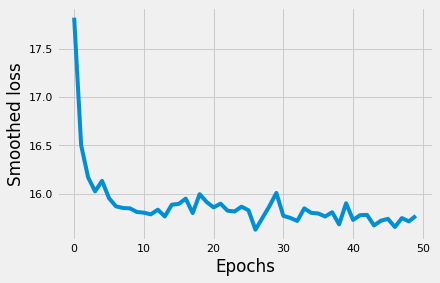

In [7]:
# Load names
with open("../data/names.txt", "r") as f:
    data = f.read()

# Convert characters to lower case
data = data.lower()

# Construct vocabulary using unique characters, sort it in ascending order,
# then construct two dictionaries that maps character to index and index to
# characters.
chars = list(sorted(set(data)))
chars_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_chars = {i: ch for ch, i in chars_to_idx.items()}

# Get the size of the data and vocab size
data_size = len(data)
vocab_size = len(chars_to_idx)
print(f"There are {data_size} characters and {vocab_size} unique characters.")

# Fitting the model
parameters, loss = model(
    "../data/names.txt", chars_to_idx, idx_to_chars, 10, vocab_size, 50, 0.01
)

# Plotting the loss
plt.plot(range(len(loss)), loss)
plt.xlabel("Epochs")
plt.ylabel("Smoothed loss")

### Results Analysis

As training progresses, the generated names evolve from random character soup to increasingly plausible names. By around epoch 15, the model has learned basic phonotactic patterns — which character combinations sound like real names. One of the interesting generated names is "Yasira," which is an actual Arabic name — the model has learned cross-cultural naming patterns purely from statistical regularities!

The loss curve shows a typical pattern for character-level models: rapid initial decrease (learning basic character frequencies), followed by slower improvement (learning positional and contextual patterns).

## What We Learned — and What Comes Next

We built a complete character-level language model from scratch: vocabulary construction, forward propagation through an RNN, backpropagation through time, gradient clipping, and probabilistic sampling. The model learned to generate plausible names from 5,163 training examples using just 10 hidden units.

### Key Takeaways

- **The core autoregressive loop** — predict next token, feed prediction back as input — is identical across all neural language models, from this character RNN to large-scale LSTM systems used in production.
- **Sampling strategy matters.** The same model produces gibberish (uniform sampling), boring repetition (greedy), or creative-yet-plausible names (distribution sampling). Temperature scaling gives fine-grained control over this spectrum.
- **Gradient instabilities are fundamental to RNNs.** Shared weights across time steps cause gradients to explode or vanish exponentially with sequence length. Clipping handles explosions; architectural changes (LSTM, GRU, attention) handle vanishing.
- **SGD with batch size 1 works but is slow.** Increasing batch size (e.g., packing multiple names into sequences of 50 characters) would speed up learning and improve gradient estimates.
- With the sampling technique we're using, don't expect the RNN to generate meaningful sequence of characters (names).
- We can control the level of randomness using the sampling strategy. Here, we balanced between what the model thinks its the right character and the level of randomness.

### Scaling Up: What Would Change?

This model is a starting point. If we have more data, bigger model, and train longer we may get more interesting results. To generate more interesting and realistic text, the natural next steps are:

| This Model | Production Systems |
|---|---|
| Characters (27 tokens) | Word-level or BPE subword vocabularies (10K–50K tokens) |
| Single-layer RNN (10 hidden units) | Multi-layer LSTM (1,000+ hidden units per layer) |
| SGD + RMSProp, batch size 1 | Adam optimizer, mini-batches of 64–256 sequences |
| 5K names | Millions of sentences (Wikipedia, books, web text) |
| CPU, seconds to train | GPUs, hours to days of training |

People have used 3-layer deep LSTM models with dropout and achieved impressive results on tasks like generating Shakespeare poems and cooking recipes. LSTM models outperform simple RNNs due to their ability to capture longer-range temporal dependencies. The recently proposed Transformer architecture ([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)), which replaces recurrence entirely with self-attention, is showing very promising results for sequence modeling and may reshape how we build language models going forward.

::: {.callout-note}
## What Stays the Same at Scale
Regardless of scale, the *concepts* remain the same: conditional probability factorization, teacher forcing, cross-entropy loss, gradient-based optimization, and the sampling trade-off. Understanding them at this small scale makes the jump to larger systems far more intuitive.
:::